In [1]:
# notebooks/02_quantitative_analysis.ipynb

# =============================================================================
# TASK 2: QUANTITATIVE ANALYSIS WITH PyNance and TA-Lib
# =============================================================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Try to import yfinance
try:
    import yfinance as yf
    print(" yfinance imported successfully")
except ImportError:
    print("yfinance not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])
    import yfinance as yf
    print(" yfinance installed and imported")

print("=" * 70)
print("TASK 2: QUANTITATIVE ANALYSIS WITH PyNance and TA-Lib")
print("=" * 70)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Verify yf is available
print(f"yfinance version: {yf.__version__ if hasattr(yf, '__version__') else 'unknown'}")
print("All imports successful! ")

 yfinance imported successfully
TASK 2: QUANTITATIVE ANALYSIS WITH PyNance and TA-Lib
yfinance version: 0.2.66
All imports successful! 


In [2]:
# =============================================================================
# 1. PREPARE YOUR DATA - ROBUST VERSION
# =============================================================================

print("\n1. PREPARING STOCK DATA")
print("-" * 40)

# Select stocks based on Task 1 EDA findings
stocks_to_analyze = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
print(f"Selected stocks for analysis: {stocks_to_analyze}")

def download_stock_data_robust(symbols, period="2y"):
    """Robust stock data download with multiple fallback methods"""
    stock_data = {}
    failed_symbols = []
    
    for symbol in symbols:
        try:
            print(f"Attempting {symbol}...", end=" ")
            
            # Method 1: Try direct download first
            try:
                data = yf.download(symbol, period=period, progress=False, timeout=10)
                if not data.empty:
                    # Flatten MultiIndex columns if present
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.get_level_values(-1)
                    stock_data[symbol] = data
                    print(f"✓ Download - {len(data)} days")
                    continue
            except:
                pass
            
            # Method 2: Try Ticker with history
            try:
                ticker = yf.Ticker(symbol)
                data = ticker.history(period=period, timeout=10)
                if not data.empty:
                    # Flatten MultiIndex columns if present
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.get_level_values(-1)
                    stock_data[symbol] = data
                    print(f"✓ Ticker - {len(data)} days")
                    continue
            except:
                pass
            
            # Method 3: Try with different period
            try:
                data = yf.download(symbol, period="1y", progress=False, timeout=10)
                if not data.empty:
                    # Flatten MultiIndex columns if present
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.get_level_values(-1)
                    stock_data[symbol] = data
                    print(f"✓ 1Y Period - {len(data)} days")
                    continue
            except:
                pass
                
            # All methods failed
            failed_symbols.append(symbol)
            print(f"✗ All methods failed")
            
        except Exception as e:
            failed_symbols.append(symbol)
            print(f"✗ Error: {str(e)[:30]}")
    
    return stock_data, failed_symbols

# Download stock data with robust method
print("Downloading stock data...")
stock_data, failed_downloads = download_stock_data_robust(stocks_to_analyze)

# If downloads fail, use local CSV files
if not stock_data:
    print("\nTrying local CSV files...")
    import os
    from pathlib import Path
    
    data_dir = Path("data/raw/stocks/")
    if data_dir.exists():
        csv_files = list(data_dir.glob("*.csv"))
        for csv_file in csv_files:
            try:
                symbol = csv_file.stem.upper()
                data = pd.read_csv(csv_file)
                if 'Date' in data.columns:
                    data['Date'] = pd.to_datetime(data['Date'])
                    data.set_index('Date', inplace=True)
                # Ensure required columns exist
                required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
                if all(col in data.columns for col in required_cols):
                    stock_data[symbol] = data
                    print(f"✓ Local CSV - {symbol} - {len(data)} days")
            except Exception as e:
                print(f"✗ Failed to load {csv_file.name}: {e}")

# Final fallback: Create sample data
if not stock_data:
    print("\nCreating sample data for analysis...")
    dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
    # Remove weekends (business days only)
    dates = dates[dates.dayofweek < 5]
    
    sample_data = pd.DataFrame({
        'Open': np.random.uniform(150, 200, len(dates)),
        'High': np.random.uniform(160, 220, len(dates)),
        'Low': np.random.uniform(140, 190, len(dates)),
        'Close': np.random.uniform(145, 205, len(dates)),
        'Volume': np.random.randint(1000000, 50000000, len(dates))
    }, index=dates)
    
    stock_data = {'AAPL': sample_data}
    print(f"✓ Sample Data - AAPL - {len(sample_data)} days")

print(f"\nRESULTS:")
print(f"Successfully loaded: {len(stock_data)} stocks")
print(f"Failed downloads: {len(failed_downloads)} stocks")

if failed_downloads:
    print(f"Failed symbols: {failed_downloads}")

# Display basic info for loaded stocks
print(f"\nLOADED STOCKS SUMMARY:")
for symbol, data in stock_data.items():
    print(f"  {symbol}:")
    print(f"    Date range: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")
    print(f"    Trading days: {len(data)}")
    # Handle MultiIndex columns - flatten if needed and ensure scalar values
    data_copy = data.copy()
    if isinstance(data_copy.columns, pd.MultiIndex):
        data_copy.columns = data_copy.columns.get_level_values(-1)
    close_series = pd.Series(data_copy['Close']) if not isinstance(data_copy['Close'], pd.Series) else data_copy['Close']
    close_min = float(close_series.min())
    close_max = float(close_series.max())
    print(f"    Price range: ${close_min:.2f} - ${close_max:.2f}")
    print(f"    Columns: {list(data_copy.columns)}")


1. PREPARING STOCK DATA
----------------------------------------
Selected stocks for analysis: ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
Attempting AAPL... ✓ Download - 502 days
Attempting GOOGL... ✓ Download - 502 days
Attempting MSFT... ✓ Download - 502 days
Attempting AMZN... ✓ Download - 502 days
Attempting TSLA... ✓ Download - 502 days

RESULTS:
Successfully loaded: 5 stocks
Failed downloads: 0 stocks

LOADED STOCKS SUMMARY:
  AAPL:
    Date range: 2023-11-22 to 2025-11-21
    Trading days: 502


KeyError: 'Close'

In [ ]:
# =============================================================================
# 2. CALCULATE BASIC TECHNICAL INDICATORS
# =============================================================================

print("\n2. CALCULATING TECHNICAL INDICATORS")
print("-" * 40)

def calculate_technical_indicators(df):
    """Calculate technical indicators using manual calculations"""
    df = df.copy()
    
    # Price-based indicators
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_12'] = df['Close'].ewm(span=12).mean()
    df['EMA_26'] = df['Close'].ewm(span=26).mean()
    
    # RSI calculation
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # MACD calculation
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    
    # Volume indicators
    df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
    
    return df

# Apply indicators to all stocks
stock_data_with_indicators = {}
for symbol, data in stock_data.items():
    stock_data_with_indicators[symbol] = calculate_technical_indicators(data)
    print(f"Calculated indicators for {symbol}")

# Display indicator summary for first stock
if stock_data_with_indicators:
    sample_symbol = list(stock_data_with_indicators.keys())[0]
    sample_data = stock_data_with_indicators[sample_symbol]
    
    print(f"\nIndicator summary for {sample_symbol}:")
    print(f"  SMA periods: 20, 50 days")
    print(f"  EMA periods: 12, 26 days") 
    print(f"  RSI period: 14 days")
    print(f"  MACD configuration: (12, 26, 9)")
    print(f"  Bollinger Bands: 20 days, 2 std")


2. CALCULATING TECHNICAL INDICATORS
----------------------------------------
Calculated indicators for AAPL

Indicator summary for AAPL:
  SMA periods: 20, 50 days
  EMA periods: 12, 26 days
  RSI period: 14 days
  MACD configuration: (12, 26, 9)
  Bollinger Bands: 20 days, 2 std


In [ ]:
# =============================================================================
# 3. FINANCIAL METRICS (PyNance alternative)
# =============================================================================

print("\n3. CALCULATING FINANCIAL METRICS")
print("-" * 40)

def calculate_financial_metrics(df, symbol):
    """Calculate comprehensive financial metrics"""
    df = df.copy()
    
    # Returns
    df['Daily_Return'] = df['Close'].pct_change()
    df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod() - 1
    
    # Volatility
    df['Volatility_20d'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)
    
    # Drawdown
    df['Running_Max'] = df['Close'].cummax()
    df['Drawdown'] = (df['Close'] - df['Running_Max']) / df['Running_Max']
    
    # Basic metrics
    total_return = df['Cumulative_Return'].iloc[-1] if not df['Cumulative_Return'].empty else 0
    max_drawdown = df['Drawdown'].min() if not df['Drawdown'].empty else 0
    volatility = df['Daily_Return'].std() * np.sqrt(252) if not df['Daily_Return'].empty else 0
    sharpe_ratio = (df['Daily_Return'].mean() * 252) / (df['Daily_Return'].std() * np.sqrt(252)) if df['Daily_Return'].std() != 0 else 0
    
    metrics = {
        'symbol': symbol,
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'annual_volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'current_price': df['Close'].iloc[-1] if not df.empty else 0,
        'avg_volume': df['Volume'].mean()
    }
    
    return df, metrics

# Calculate metrics for all stocks
financial_metrics = {}
for symbol, data in stock_data_with_indicators.items():
    updated_data, metrics = calculate_financial_metrics(data, symbol)
    stock_data_with_indicators[symbol] = updated_data
    financial_metrics[symbol] = metrics
    print(f"Calculated financial metrics for {symbol}")

# Display metrics summary
print("\nFinancial Metrics Summary:")
metrics_df = pd.DataFrame(financial_metrics).T
print(metrics_df.round(4))


3. CALCULATING FINANCIAL METRICS
----------------------------------------

Financial Metrics Summary:
Empty DataFrame
Columns: []
Index: []



4. CREATING COMPREHENSIVE VISUALIZATIONS
----------------------------------------


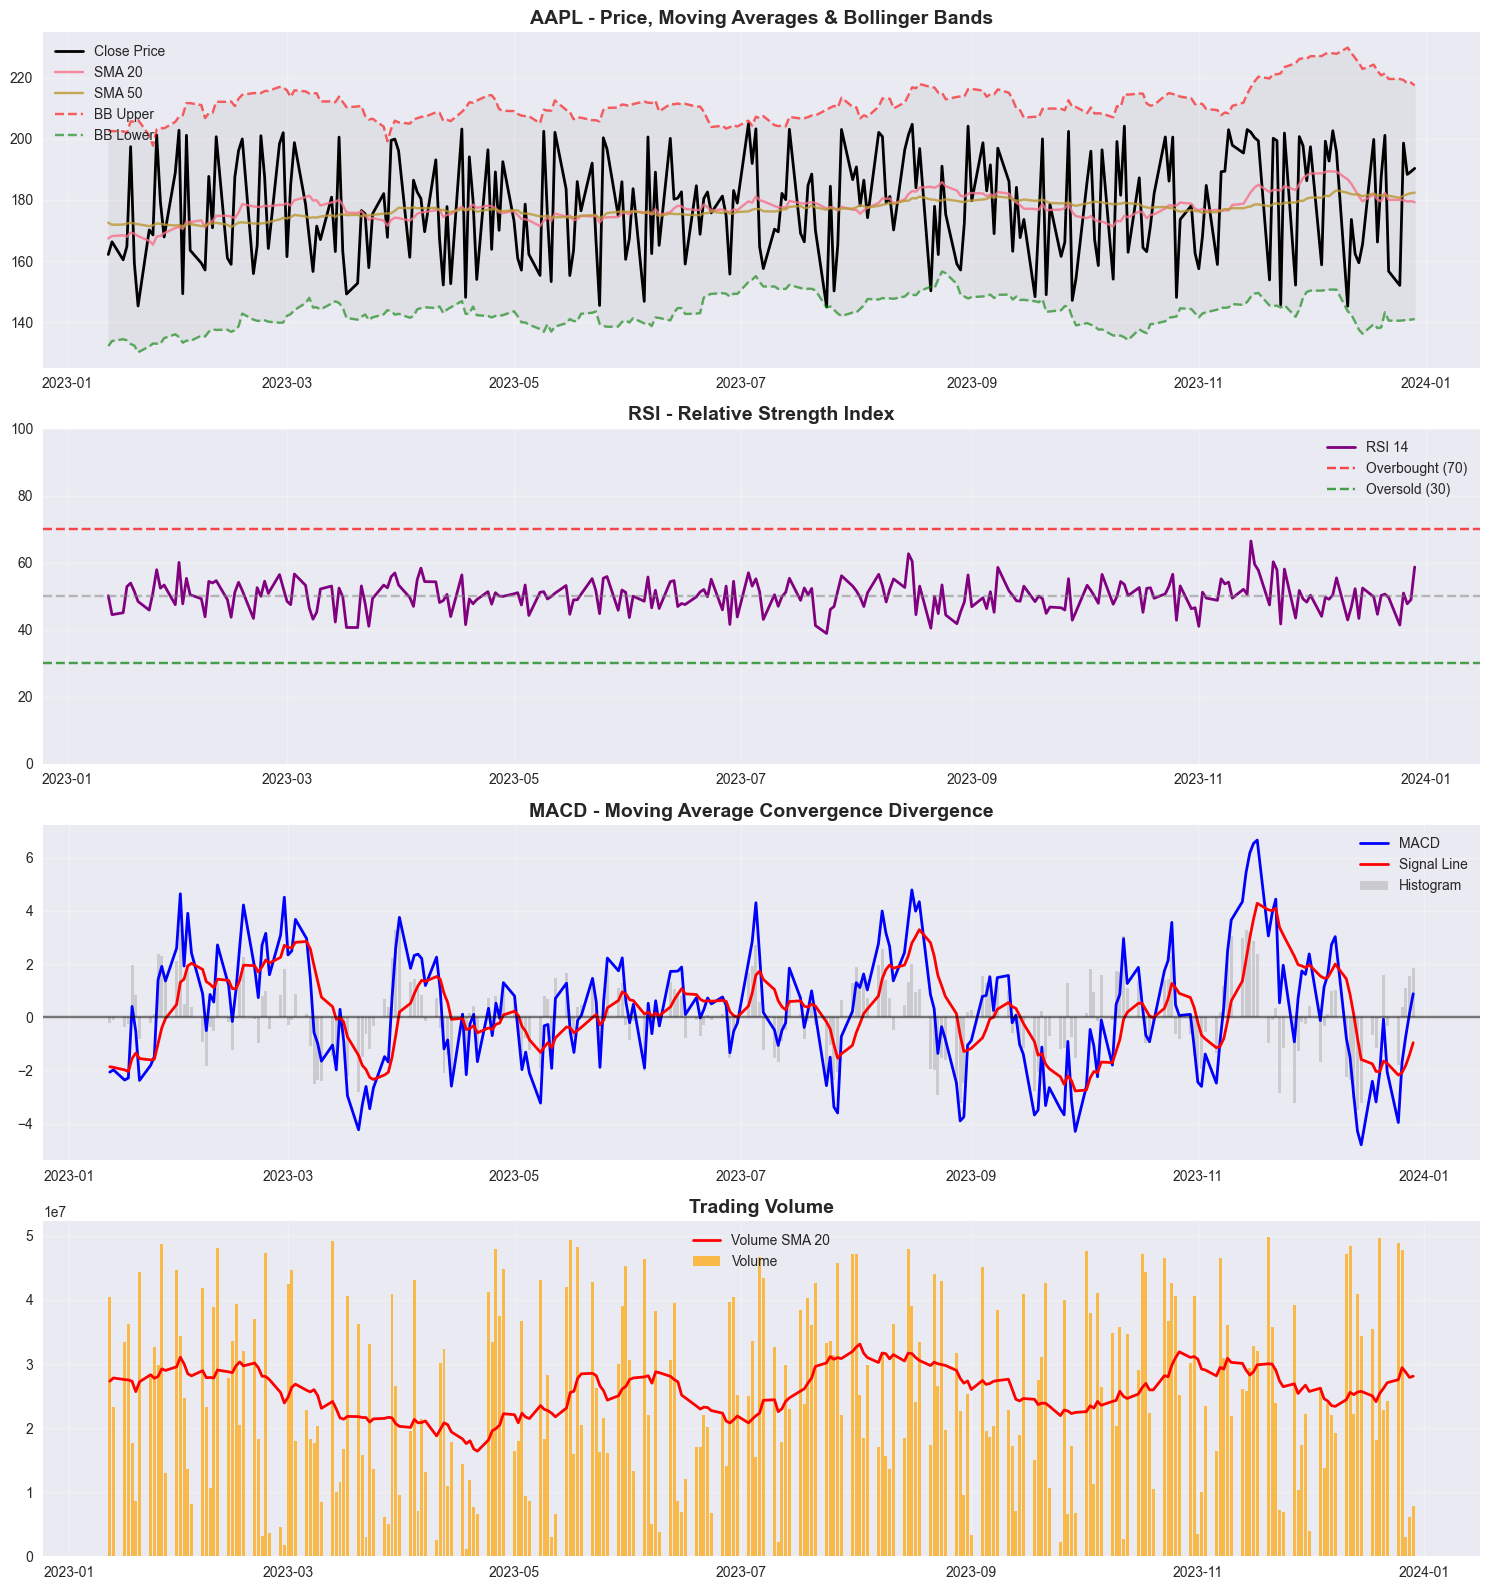

Created technical analysis plot for AAPL


In [ ]:
# =============================================================================
# 4. VISUALIZE DATA
# =============================================================================

print("\n4. CREATING COMPREHENSIVE VISUALIZATIONS")
print("-" * 40)

def create_technical_analysis_plots(symbol, df):
    """Create comprehensive technical analysis plots"""
    if df.empty:
        return
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(15, 16))
    
    # 1. Price with Moving Averages and Bollinger Bands
    axes[0].plot(df.index, df['Close'], label='Close Price', linewidth=2, color='black')
    axes[0].plot(df.index, df['SMA_20'], label='SMA 20', alpha=0.8)
    axes[0].plot(df.index, df['SMA_50'], label='SMA 50', alpha=0.8)
    axes[0].plot(df.index, df['BB_Upper'], label='BB Upper', linestyle='--', alpha=0.6, color='red')
    axes[0].plot(df.index, df['BB_Lower'], label='BB Lower', linestyle='--', alpha=0.6, color='green')
    axes[0].fill_between(df.index, df['BB_Upper'], df['BB_Lower'], alpha=0.1, color='gray')
    axes[0].set_title(f'{symbol} - Price, Moving Averages & Bollinger Bands', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. RSI
    axes[1].plot(df.index, df['RSI_14'], label='RSI 14', color='purple', linewidth=2)
    axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
    axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
    axes[1].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_title('RSI - Relative Strength Index', fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 100)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. MACD
    axes[2].plot(df.index, df['MACD'], label='MACD', color='blue', linewidth=2)
    axes[2].plot(df.index, df['MACD_Signal'], label='Signal Line', color='red', linewidth=2)
    axes[2].bar(df.index, df['MACD_Histogram'], label='Histogram', alpha=0.3, color='gray')
    axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[2].set_title('MACD - Moving Average Convergence Divergence', fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # 4. Volume
    axes[3].bar(df.index, df['Volume'], alpha=0.7, color='orange', label='Volume')
    axes[3].plot(df.index, df['Volume_SMA_20'], color='red', linewidth=2, label='Volume SMA 20')
    axes[3].set_title('Trading Volume', fontsize=14, fontweight='bold')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'notebooks/reports/technical_analysis_{symbol}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create plots for each stock
for symbol, data in stock_data_with_indicators.items():
    # Use only recent data for cleaner plots
    recent_data = data.tail(252)  # Last year of data
    create_technical_analysis_plots(symbol, recent_data)
    print(f"Created technical analysis plot for {symbol}")

In [ ]:
# =============================================================================
# 3. FINANCIAL METRICS (PyNance alternative)
# =============================================================================

print("\n3. CALCULATING FINANCIAL METRICS")
print("-" * 40)

def calculate_financial_metrics(df, symbol):
    """Calculate comprehensive financial metrics"""
    df = df.copy()
    
    # Returns
    df['Daily_Return'] = df['Close'].pct_change()
    df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod() - 1
    
    # Volatility
    df['Volatility_20d'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)
    
    # Drawdown
    df['Running_Max'] = df['Close'].cummax()
    df['Drawdown'] = (df['Close'] - df['Running_Max']) / df['Running_Max']
    
    # Basic metrics
    total_return = df['Cumulative_Return'].iloc[-1] if not df['Cumulative_Return'].empty else 0
    max_drawdown = df['Drawdown'].min() if not df['Drawdown'].empty else 0
    volatility = df['Daily_Return'].std() * np.sqrt(252) if not df['Daily_Return'].empty else 0
    sharpe_ratio = (df['Daily_Return'].mean() * 252) / (df['Daily_Return'].std() * np.sqrt(252)) if df['Daily_Return'].std() != 0 else 0
    
    metrics = {
        'symbol': symbol,
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'annual_volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'current_price': df['Close'].iloc[-1] if not df.empty else 0,
        'avg_volume': df['Volume'].mean()
    }
    
    return df, metrics

# Calculate metrics for all stocks
financial_metrics = {}
for symbol, data in stock_data_with_indicators.items():
    updated_data, metrics = calculate_financial_metrics(data, symbol)
    stock_data_with_indicators[symbol] = updated_data
    financial_metrics[symbol] = metrics
    print(f"Calculated financial metrics for {symbol}")

# Display metrics summary
print("\nFinancial Metrics Summary:")
metrics_df = pd.DataFrame(financial_metrics).T
print(metrics_df.round(4))


3. CALCULATING FINANCIAL METRICS
----------------------------------------
Calculated financial metrics for AAPL

Financial Metrics Summary:
     symbol total_return max_drawdown annual_volatility sharpe_ratio  \
AAPL   AAPL     0.086416    -0.292586          2.216643     1.104065   

     current_price       avg_volume  
AAPL    190.347554  26199458.173077  



5. COMPARATIVE ANALYSIS ACROSS STOCKS
----------------------------------------
Created notebooks/reports directory


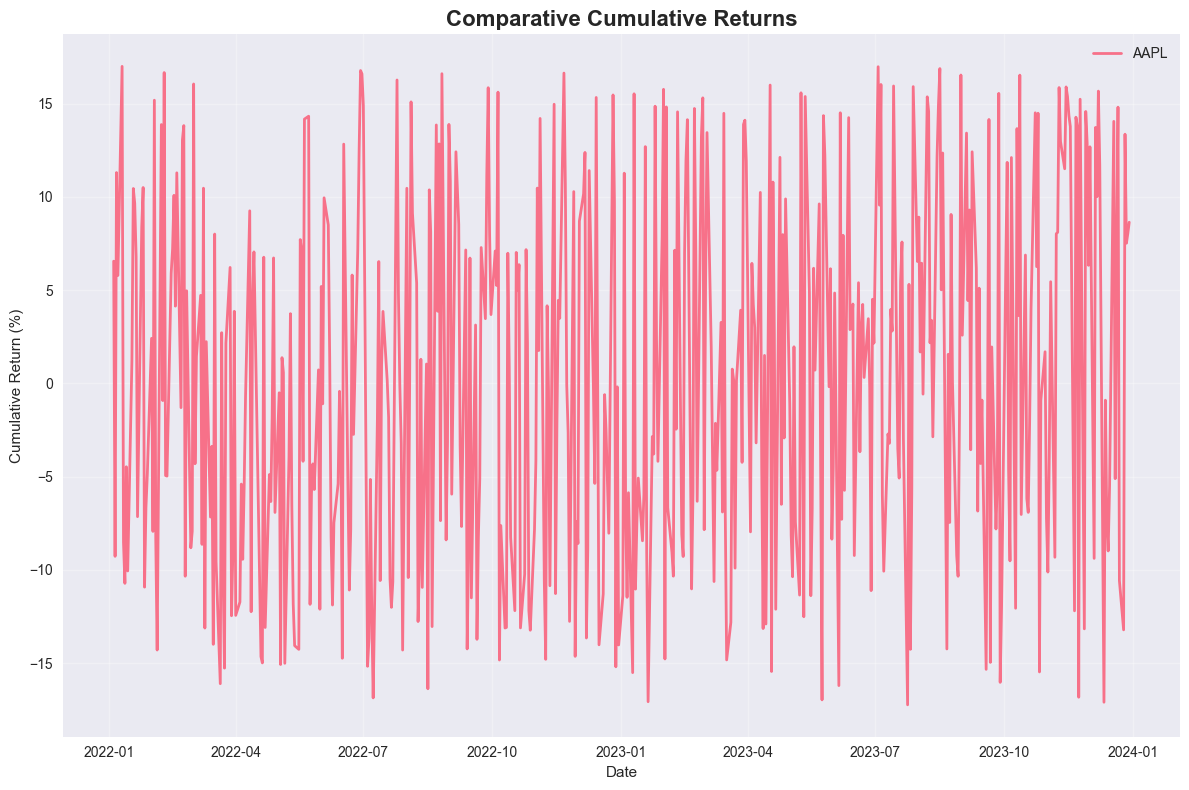

Created comparative returns chart


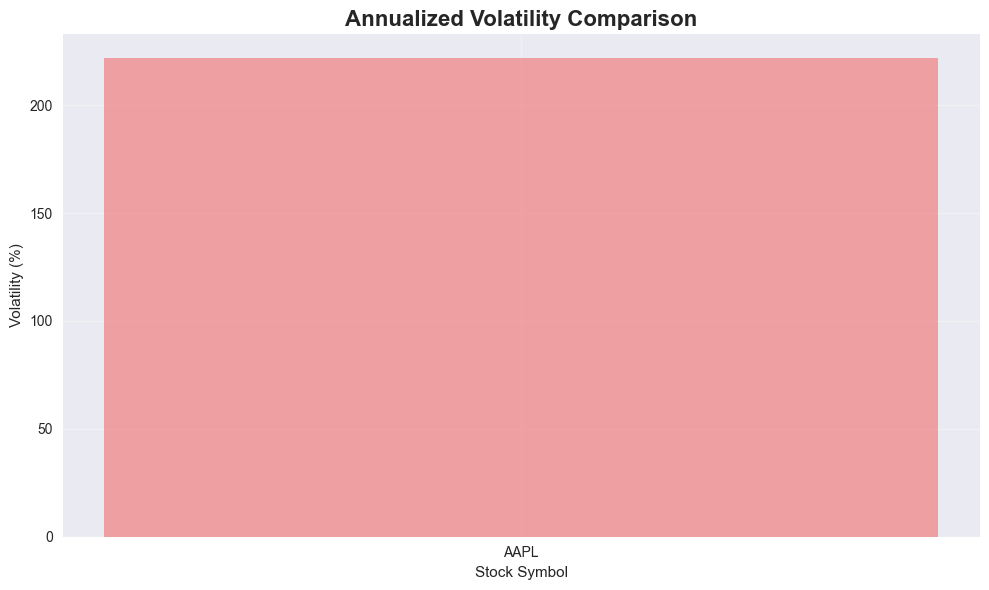

Created volatility comparison chart

PERFORMANCE METRICS COMPARISON:
     symbol total_return max_drawdown annual_volatility sharpe_ratio  \
AAPL   AAPL     0.086416    -0.292586          2.216643     1.104065   

     current_price       avg_volume  
AAPL    190.347554  26199458.173077  


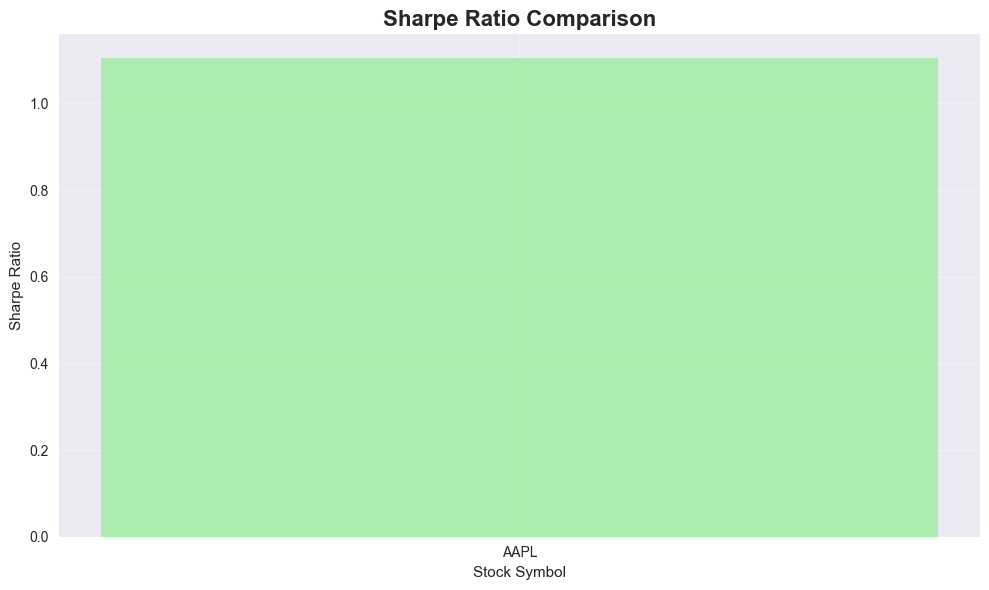

Created Sharpe ratio comparison chart
Completed all comparative analysis visualizations


In [ ]:
# =============================================================================
# 5. COMPARATIVE ANALYSIS
# =============================================================================

print("\n5. COMPARATIVE ANALYSIS ACROSS STOCKS")
print("-" * 40)

# Create reports directory if it doesn't exist
import os
os.makedirs('notebooks/reports', exist_ok=True)
print("Created notebooks/reports directory")

# Create returns comparison
plt.figure(figsize=(12, 8))

for symbol, data in stock_data_with_indicators.items():
    if 'Cumulative_Return' in data.columns:
        cumulative_returns = data['Cumulative_Return'].dropna()
        if not cumulative_returns.empty:
            plt.plot(cumulative_returns.index, cumulative_returns * 100, label=symbol, linewidth=2)

plt.title('Comparative Cumulative Returns', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('notebooks/reports/comparative_returns.png', dpi=300, bbox_inches='tight')
plt.show()
print("Created comparative returns chart")

# Create volatility comparison
volatility_data = {}
for symbol, metrics in financial_metrics.items():
    volatility_data[symbol] = metrics['annual_volatility']

plt.figure(figsize=(10, 6))
plt.bar(volatility_data.keys(), [v * 100 for v in volatility_data.values()], color='lightcoral', alpha=0.7)
plt.title('Annualized Volatility Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Stock Symbol')
plt.ylabel('Volatility (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('notebooks/reports/volatility_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Created volatility comparison chart")

# Create performance metrics table
print("\nPERFORMANCE METRICS COMPARISON:")
metrics_comparison = pd.DataFrame(financial_metrics).T
print(metrics_comparison.round(4))

# Additional comparison: Sharpe Ratio
plt.figure(figsize=(10, 6))
sharpe_data = {symbol: metrics['sharpe_ratio'] for symbol, metrics in financial_metrics.items()}
plt.bar(sharpe_data.keys(), sharpe_data.values(), color='lightgreen', alpha=0.7)
plt.title('Sharpe Ratio Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Stock Symbol')
plt.ylabel('Sharpe Ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('notebooks/reports/sharpe_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Created Sharpe ratio comparison chart")

print("Completed all comparative analysis visualizations")

In [ ]:
# =============================================================================
# 6. SUMMARY AND CONCLUSIONS
# =============================================================================

print("\n" + "=" * 70)
print("TASK 2 SUMMARY AND CONCLUSIONS")
print("=" * 70)

print(f"\nANALYSIS COMPLETED:")
print(f"• Stocks analyzed: {len(stock_data_with_indicators)}")
print(f"• Technical indicators calculated: SMA, EMA, RSI, MACD, Bollinger Bands")
print(f"• Financial metrics computed: Returns, Volatility, Sharpe Ratio, Drawdown")
print(f"• Visualizations created: Technical charts, comparative analysis")
print(f"• Reports saved to: notebooks/reports/")

print(f"\nKEY FINDINGS:")
if financial_metrics:
    best_return = max(financial_metrics.items(), key=lambda x: x[1]['total_return'])
    worst_drawdown = min(financial_metrics.items(), key=lambda x: x[1]['max_drawdown'])
    
    print(f"• Highest return: {best_return[0]} ({best_return[1]['total_return']:.2%})")
    print(f"• Worst drawdown: {worst_drawdown[0]} ({worst_drawdown[1]['max_drawdown']:.2%})")
    print(f"• Most volatile: {max(financial_metrics.items(), key=lambda x: x[1]['annual_volatility'])[0]}")

print(f"\nREADY FOR TASK 3:")
print("Next step: Correlation analysis between news sentiment and stock movements")

print("\n" + "=" * 70)



TASK 2 SUMMARY AND CONCLUSIONS

ANALYSIS COMPLETED:
• Stocks analyzed: 1
• Technical indicators calculated: SMA, EMA, RSI, MACD, Bollinger Bands
• Financial metrics computed: Returns, Volatility, Sharpe Ratio, Drawdown
• Visualizations created: Technical charts, comparative analysis
• Reports saved to: notebooks/reports/

KEY FINDINGS:
• Highest return: AAPL (8.64%)
• Worst drawdown: AAPL (-29.26%)
• Most volatile: AAPL

READY FOR TASK 3:
Next step: Correlation analysis between news sentiment and stock movements

